[S001] Found 19 participants after filtering.
[S001] Successfully loaded 19 out of 19 participants.
[S002] Found 19 participants after filtering.
[S002] Successfully loaded 19 out of 19 participants.


C:\Users\lal\AppData\Local\Temp\ipykernel_15912\1124706275.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # leave room on right for legend


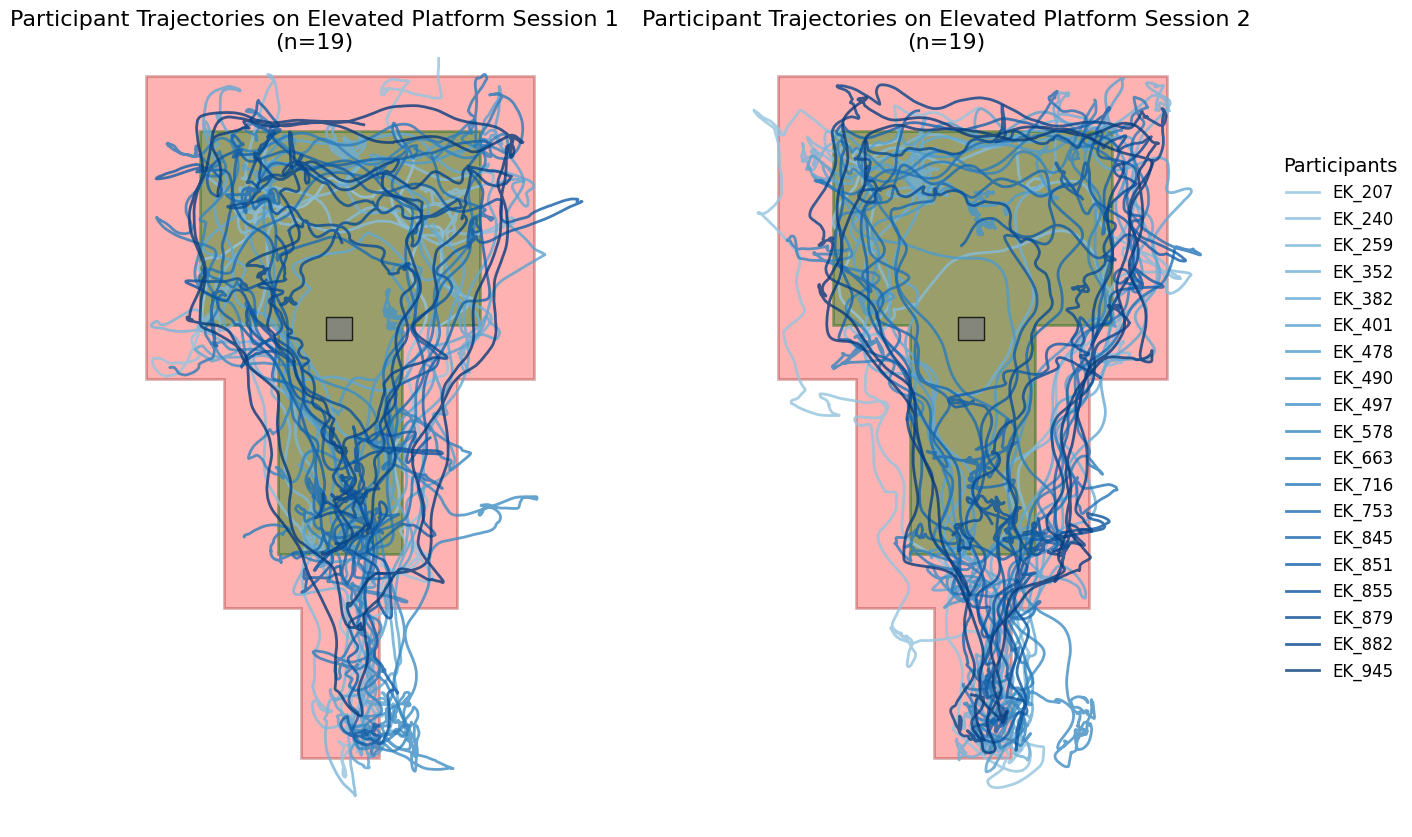

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import glob
from datetime import datetime, timedelta

# --- Coordinates ---
coords = {
    "pillar": [
        (-6.21, 5.14),
        (-6.21, 4.96),
        (-6.41, 4.96),
        (-6.41, 5.14)
    ],
    'platform': {
        'outer': [
            (-6.00, 1.73), (-6.60, 1.73), (-6.60, 2.89), (-7.20, 2.89),
            (-7.20, 4.66), (-7.80, 4.66), (-7.80, 7.00), (-4.80, 7.00),
            (-4.80, 4.66), (-5.40, 4.66), (-5.40, 2.89), (-6.00, 2.89)
        ],
        'inner': [
            (-6.78, 3.31), (-6.78, 5.08), (-7.38, 5.08),
            (-7.38, 6.58), (-5.22, 6.58), (-5.22, 5.08),
            (-5.82, 5.08), (-5.82, 3.31)
        ]
    }
}

# --- Skip participants ---
skip_participants = [
    'EK_260', 'EK_303', 'EK_418', 'EK_424', 'EK_645', 
    'EK_648', 'EK_711', 'EK_715', 'EK_795', 'EK_951', 
    'EK_963', 'EK_993'
]

# --- Base directory ---
base_dir = r'D:\vr-pipeline\data\RAW1'

# --- Sessions ---
sessions = ['S001', 'S002']
titles = ['Participant Trajectories on Elevated Platform Session 1',
          'Participant Trajectories on Elevated Platform Session 2']

# --- Create figure ---
fig, axes = plt.subplots(1, 2, figsize=(16, 10), gridspec_kw={'wspace': 0.04})

# --- Collect participant labels for shared legend ---
all_participant_ids = []

# --- Loop over sessions ---
for idx, (session, title) in enumerate(zip(sessions, titles)):
    ax = axes[idx]

    # --- Find files ---
    pattern = os.path.join(base_dir, '*', session, 'trackers_rotated', 'camera_movement_T011.csv')
    file_paths = glob.glob(pattern)

    # --- Extract participants ---
    participant_data = []
    for file_path in file_paths:
        parts = file_path.split(os.sep)
        participant_id = parts[parts.index('RAW1') + 1]

        if participant_id not in skip_participants:
            participant_data.append((file_path, participant_id))

    participant_data.sort(key=lambda x: x[1])

    print(f"[{session}] Found {len(participant_data)} participants after filtering.")

    # --- Background patches ---
    outer_polygon = patches.Polygon(coords['platform']['outer'], 
                                    fill=True, facecolor='red', alpha=0.3,
                                    edgecolor='darkred', linewidth=2)
    ax.add_patch(outer_polygon)

    inner_polygon = patches.Polygon(coords['platform']['inner'], 
                                    fill=True, facecolor='green', alpha=0.4,
                                    edgecolor='darkgreen', linewidth=2)
    ax.add_patch(inner_polygon)

    pillar_polygon = patches.Polygon(coords['pillar'], 
                                     fill=True, facecolor='gray', 
                                     edgecolor='black', linewidth=1, alpha=0.8)
    ax.add_patch(pillar_polygon)

    # --- Colors ---
    n_participants = len(participant_data)
    blues = plt.cm.Blues(np.linspace(0.4, 0.95, n_participants))

    # --- Plot trajectories ---
    successful_loads = 0
    for i, (file_path, participant_id) in enumerate(participant_data):
        try:
            df = pd.read_csv(file_path)
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='%m/%d/%Y %H:%M:%S')

            start_time = df['timestamp'].iloc[0]
            time_window_start = start_time + timedelta(seconds=30)
            time_window_end = start_time + timedelta(seconds=120)

            filtered_df = df[(df['timestamp'] >= time_window_start) & 
                             (df['timestamp'] <= time_window_end)]

            if filtered_df.empty:
                print(f"[{session}] No data in time window for {participant_id}")
                continue

            x_coords = filtered_df['pos_x'].values
            z_coords = filtered_df['pos_z'].values

            line, = ax.plot(x_coords, z_coords, 
                            color=blues[i], linewidth=2, alpha=0.8, zorder=10, 
                            label=participant_id)

            all_participant_ids.append((participant_id, line))

            successful_loads += 1

        except Exception as e:
            print(f"[{session}] Error loading {participant_id}: {str(e)}")

    print(f"[{session}] Successfully loaded {successful_loads} out of {n_participants} participants.")

    # --- Axis styling ---
    ax.set_xlim(-8.7, -4.3)
    ax.set_ylim(1.2, 7.15)
   
    ax.set_aspect('equal')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    for spine in ax.spines.values():
        spine.set_visible(False)

    # --- Title ---
    ax.set_title(f'{title}\n(n={successful_loads})', fontsize=16)

# --- Deduplicate participants for legend ---
unique_participants = {}
for pid, handle in all_participant_ids:
    if pid not in unique_participants:
        unique_participants[pid] = handle

# --- Shared legend at right ---
fig.legend(unique_participants.values(), unique_participants.keys(),
           title="Participants", fontsize=12, title_fontsize=14,
           loc='center right',
             #bbox_to_anchor=(1.02, 0.5),
               frameon=False)

# --- Final layout ---
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # leave room on right for legend
plt.show()
